<a href="https://colab.research.google.com/github/Tonyrj3268/DS4CS-FinalProject/blob/main/%E6%96%B0%E5%9E%8B%E6%BC%94%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Member**
*   林家誠, 109306066, MIS
*   陳彥竹, 1093060xx, MIS



# **Title**
**url之分析...**

# **Problem Definition**
**Problem Definition**

# **Dataset**
**Dataset**
**介紹**



# **description of your models**
**models**
**介紹**



# **result**
**介紹**



# **discussion**
**介紹**


# 程式碼

## 安裝套件

In [147]:
!pip install transformers
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 下載和解壓檔案

In [148]:
import requests
import zipfile

url = 'https://github.com/Tonyrj3268/DS4CS-FinalProject/raw/main/archive.zip'
response = requests.get(url)
with open('archive.zip', 'wb') as file:
    file.write(response.content)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 加載模組

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import string
from urllib.parse import urlparse
import re
from transformers import BertModel, BertTokenizer
import torch
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## gpu check

In [150]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 分析資料集

In [151]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


由於資料集的label分配不均，且資料太過龐大(65萬筆)，使用欠採樣平衡數據集並且縮小訓練資料量，原本呈現之結果為欠採樣後之訓練數量。


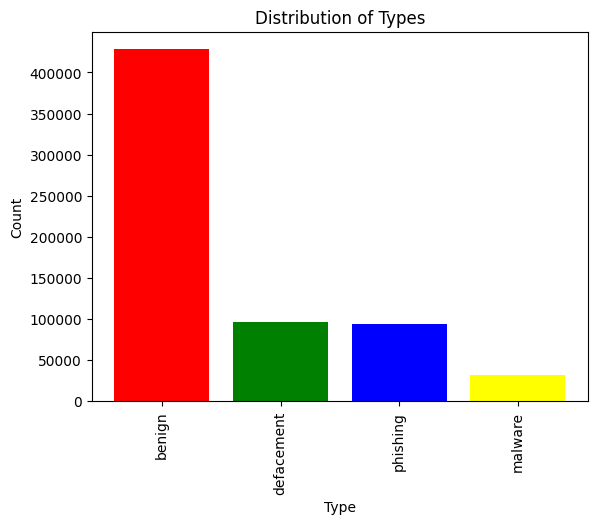

In [152]:
category_counts = df['type'].value_counts()
colors = ['red', 'green', 'blue', 'yellow']
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Types")
plt.xticks(rotation='vertical')
plt.show()

In [153]:
X = df[['url']]
y = df['type']

under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

print("處理後的樣本數:", len(X_resampled))
print("處理後的樣本分佈:")
print(y_resampled.value_counts())

re_df = pd.concat([X_resampled, y_resampled], axis=1)
re_df = re_df.sample(n=10000, random_state=42)

處理後的樣本數: 130080
處理後的樣本分佈:
benign        32520
defacement    32520
malware       32520
phishing      32520
Name: type, dtype: int64


# 預處理

## 特殊字符
計算特殊字符之數量，若完全沒該字符出現，則捨棄此字符欄位。

In [154]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=',\
         '{', '}', '[', ']', '|', '\\', ':', ';', '<', '>', ',', '.', '?', '/', '`', '~']  # 定义特殊字符列表

for a in special_chars:
    re_df[a] = re_df['url'].apply(lambda i: i.count(a))
absent_chars = [char for char in special_chars if re_df[char].sum() == 0]
re_df.drop(columns=absent_chars, inplace=True)

## https 檢查 & url長度計算
檢查是否帶有https字串，如有則計為1。
計算url之總長度

In [155]:
def httpSecure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        return 1
    else:
        return 0
re_df['https'] = re_df['url'].apply(lambda i: httpSecure(i))
re_df['url_len'] = re_df['url'].apply(lambda i: len(str(i)))

In [156]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 115240 to 117856
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      10000 non-null  object
 1   type     10000 non-null  object
 2   !        10000 non-null  int64 
 3   @        10000 non-null  int64 
 4   #        10000 non-null  int64 
 5   $        10000 non-null  int64 
 6   %        10000 non-null  int64 
 7   ^        10000 non-null  int64 
 8   &        10000 non-null  int64 
 9   *        10000 non-null  int64 
 10  (        10000 non-null  int64 
 11  )        10000 non-null  int64 
 12  _        10000 non-null  int64 
 13  -        10000 non-null  int64 
 14  +        10000 non-null  int64 
 15  =        10000 non-null  int64 
 16  {        10000 non-null  int64 
 17  }        10000 non-null  int64 
 18  [        10000 non-null  int64 
 19  ]        10000 non-null  int64 
 20  |        10000 non-null  int64 
 21  \        10000 non-null  int6

## 加載bert模型

In [157]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')#bert-base-uncased
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 切割url
1.  將url的特殊字符去除，獲得剩餘單字詞的集合，例如:www.example.com => [www, example, com]。
2.  使用已訓練好的tokenizer獲得單詞之token ID，將token集合放入bert 模型生成1維768長度的值
3.  display mode預估訓練時間3分半

In [158]:
def urlSplitBatch(urls):
    url_parts = [re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', ' ', url)).split(' ') for url in urls]
    tokens = [tokenizer.batch_encode_plus(parts, padding=True, truncation=True, return_tensors='pt') for parts in url_parts]
    input_ids = [token["input_ids"] for token in tokens]
    url_vectors = []
    for ids in input_ids:
      with torch.no_grad():
          ids = ids.to(device)
          last_hidden_states = model(ids)[0]
      url_vectors.append(last_hidden_states.mean(dim=[0, 1]).unsqueeze(0))

    url_vectors = torch.cat(url_vectors, dim=0).to(device)
    return url_vectors


# 在主要迴圈中使用批次處理
BATCH_SIZE = 1000 # 你可以根據你的硬體配置和需求來調整批次的大小
word_vector = []
rows_to_drop = []
total = len(re_df['url'])
checkpoint = total // 100
for start in range(0, total, BATCH_SIZE):
  end = min(start + BATCH_SIZE, total)
  batch_indices = re_df.index[start:end]
  batch = re_df['url'].loc[batch_indices]
  try:
    split_urls = urlSplitBatch(batch)  # 對整個批次進行split操作
  except:
    print(f"第{start}批資料集發生錯誤，跳過並移除")
    rows_to_drop.extend(batch_indices)  # 若split操作失敗，將整個批次的索引加入要刪除的列表
    continue

  list_from_tensor = split_urls.tolist()
  word_vector.extend(list_from_tensor)

  if end % checkpoint == 0:
      print("已完成：{:.0f}%".format(end / total * 100))

已完成：10%
已完成：20%
已完成：30%
已完成：40%
已完成：50%
已完成：60%
已完成：70%
已完成：80%
已完成：90%
已完成：100%


In [159]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        mid_dim = (input_dim + encoding_dim) // 2  # add an intermediate layer with average dimension

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, encoding_dim),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, input_dim),
        )

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x


In [160]:
input_dim = len(word_vector[0])  # number of features
encoding_dim = 200  # desired dimension after encoding

model = AutoEncoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
EPOCHES = 20

features = torch.from_numpy(np.array(word_vector)).float().to(device)
dataset = TensorDataset(features)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

for epoch in range(EPOCHES):
    for feature in data_loader:
        # forward
        outputs = model(feature[0])
        loss = criterion(outputs, feature[0])

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{EPOCHES}], Loss: {loss.item():.4f}')
with torch.no_grad():
    encoded_data = model.encoder(features)

Epoch [1/20], Loss: 0.0026
Epoch [2/20], Loss: 0.0022
Epoch [3/20], Loss: 0.0028
Epoch [4/20], Loss: 0.0018
Epoch [5/20], Loss: 0.0025
Epoch [6/20], Loss: 0.0016
Epoch [7/20], Loss: 0.0017
Epoch [8/20], Loss: 0.0021
Epoch [9/20], Loss: 0.0013
Epoch [10/20], Loss: 0.0014
Epoch [11/20], Loss: 0.0014
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0012
Epoch [14/20], Loss: 0.0022
Epoch [15/20], Loss: 0.0017
Epoch [16/20], Loss: 0.0008
Epoch [17/20], Loss: 0.0015
Epoch [18/20], Loss: 0.0013
Epoch [19/20], Loss: 0.0011
Epoch [20/20], Loss: 0.0015


## 切分成3種特徵
1.  純單字詞矩陣
2.  純原url之特徵矩陣
3.  上面兩種之結合

In [161]:
word_vector_array = encoded_data.cpu()
feature_array = re_df.drop(['url', 'type'], axis=1).drop(rows_to_drop).to_numpy()
merged_array = np.hstack((feature_array, word_vector_array))

target = pd.get_dummies(re_df['type'], columns=['type'])

In [162]:
features_train, features_test, labels_train, labels_test = train_test_split(merged_array, target.values, test_size=0.2, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

# numpy轉換tensors
features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32)
features_val = torch.tensor(features_val, dtype=torch.float32)
labels_val = torch.tensor(labels_val, dtype=torch.float32)
features_test = torch.tensor(features_test, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)

train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)
test_dataset = TensorDataset(features_test, labels_test)

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

fast_train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
fast_test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
fast_val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)

## 神經網路
使用神經網路對三種資料集進行訓練

In [163]:
class FeatureNet(nn.Module):
    def __init__(self, x_len):
        super(FeatureNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.log_softmax(self.fc3(x), dim=1)
        return x
class WordNet(nn.Module):
    def __init__(self, x_len):
        super(WordNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 100)
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)  # 使用 LogSoftmax
        return x
    def forward_act(self, x):
        x = F.relu(self.fc1(x))
        return x

In [164]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [182]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss = 0
    correct = 0
    running_loss = 0
    total = 0
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.argmax(dim=1).to(device)
      # Compute prediction and loss
      outputs = model(inputs)

      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()# 梯度初始化为零
      loss.backward()# 反向传播求梯度
      optimizer.step()# 更新所有参数

      #計算數字機率分布
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    avg_train_loss = running_loss / len(dataloader)
    train_accuracy = correct / total

    return avg_train_loss, train_accuracy
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss = correct = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

    test_loss /= size

    return test_loss
def val_loop(dataloader, model, loss_fn):
    running_loss = 0.0
    total = 0
    correct = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_loss / len(dataloader)
    train_accuracy = correct / total

    return avg_val_loss, train_accuracy

In [166]:
def init_weights_kaiming_normal_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [190]:
model_wt = WordNet(len(merged_array[0]))
model_wt.to(device)
model_wt.apply(init_weights_kaiming_normal_)
feature_arrays = merged_array
Epoch = 5
loss_results = {}
accuracy_results = {}
loss_results_val = {}
accuracy_results_val = {}

early_stopping = EarlyStopping(patience=5, verbose=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_wt.parameters())

losses = []
accuracies = []
losses_val = []
accuracies_val = []

for epoch in range(Epoch):
  loss, acc = train_loop(train_dataloader, model_wt, criterion, optimizer)
  accuracies.append(acc)
  losses.append(loss)
  if epoch % 1 == 0:
      print(f'Epoch {epoch + 1}, Training Loss: {loss}, Training Acc: {acc}')

  val_loss, val_accuracy = val_loop(val_dataloader, model_wt, criterion)
  accuracies_val.append(val_accuracy)
  losses_val.append(val_loss)
  print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Acc: {val_accuracy}')
  # Check early stopping
  early_stopping(val_loss)
  if early_stopping.early_stop:
      print("Early stopping")
      break
loss_results["Weight Tuning"] = losses
accuracy_results["Weight Tuning"] = accuracies
loss_results_val["Weight Tuning"] = losses_val
accuracy_results_val["Weight Tuning"] = accuracies_val

Epoch 1, Training Loss: 0.89294131211509, Training Acc: 0.6715625
Epoch 1, Validation Loss: 0.5984781340248628, Validation Acc: 0.755
Epoch 2, Training Loss: 0.6581886335576596, Training Acc: 0.7559375
Epoch 2, Validation Loss: 0.6190198774096944, Validation Acc: 0.761875
EarlyStopping counter: 1 out of 5
Epoch 3, Training Loss: 0.5689012973279497, Training Acc: 0.78453125
Epoch 3, Validation Loss: 0.7302557951336268, Validation Acc: 0.746875
EarlyStopping counter: 2 out of 5
Epoch 4, Training Loss: 0.5225628789555783, Training Acc: 0.79921875
Epoch 4, Validation Loss: 0.5117304201480988, Validation Acc: 0.80875
Epoch 5, Training Loss: 0.48806045838931633, Training Acc: 0.81453125
Epoch 5, Validation Loss: 0.45439626333020444, Validation Acc: 0.826875


In [191]:
false_index = []
criterion = nn.NLLLoss()
predicts = []
labels = []
losses = []
model_wt.eval()
for index, (X, y) in enumerate(train_dataloader):
  y_pred = model_wt(X.to(device))
  y = y.argmax(dim=1).to(device)

  loss = criterion(y_pred, y)
  losses.append(loss.item())

  # pred_class = torch.argmax(y_pred, dim=1)
  # true_class = y
  predicts.append(y_pred)
  labels.append(y)

threshold = np.percentile(losses, 99.8)

# 创建空的false_index列表
false_index = []

# 遍历losses列表，找出大于阈值的损失的索引
for i, loss_value in enumerate(losses):
    if loss_value > threshold:
        false_index.append(i)
print("Threshold:", threshold)
print("False indices:", false_index)
print("False length", len(false_index))

Threshold: 5.927920982360861
False indices: [270, 1069, 1342, 2667, 2739, 4140, 4354, 4405, 4613, 4632, 5471, 5557, 5806]
False length 13


In [192]:
old_fc1 = model_wt.fc1
old_weight = old_fc1.weight.data
old_bias = old_fc1.bias.data
old_fc2 = model_wt.fc2
old_fc2_weight = old_fc2.weight.data
old_fc2_bias = old_fc2.bias.data

In [193]:
import copy

Found = False
new_model = copy.deepcopy(model_wt)

def activation(x):
  return model_wt.forward_act(x)
if len(false_index) > 0:
  out = 100+3*len(false_index)
  new_fc1 = nn.Linear(in_features=len(merged_array[0]), out_features=out)
  new_fc1.weight.data[:100] = old_weight
  new_fc1.bias.data[:100] = old_bias
  new_fc2 = nn.Linear(in_features=out, out_features=4)
  new_fc2.weight.data[:,:100] = old_fc2_weight
  new_fc2.bias.data = old_fc2_bias
features_train = features_train.to(device)
for false_i,kappa_index in enumerate(false_index):
  while not Found:
    z = 1e-3
    vec = torch.randn(len(merged_array[0]), 1)
    norm = vec.norm(p=2, dim=0, keepdim=True)
    unit_vec = vec / norm #64*1

    for i in range(len(features_train)):
      if i in false_index:
        continue

      H = ((unit_vec.reshape(1, len(merged_array[0])).to(device))@(features_train[i] - features_train[kappa_index]).reshape(len(merged_array[0]),1)).item()
      if H != 0 and (z+H)*(z-H) < 0:
        Found = True
        continue
      Found = False

  gamma = unit_vec.reshape(1,len(merged_array[0])).to(device)
  kappa = features_train[kappa_index].reshape(len(merged_array[0]),1)
  b1 = z - (gamma @ kappa).item()
  b2 = - (gamma @ kappa).item()
  b3 = -z - (gamma @ kappa).item()

  new_fc1.weight.data[100+3*(false_i):100+3*(false_i+1)] = gamma.repeat(3, 1)  # 将所有权重设置为1.0
  new_fc1.bias.data[100+3*(false_i):100+3*(false_i+1)]= torch.tensor([b1, b2, b3])
  for i in range(4):
    total = 0
    act = activation(features_train[kappa_index:kappa_index+1])
    for j in range(100):
      total += new_fc2.weight.data[i][j] * act[0][j]

    new_fc2.weight.data[i,100+3*false_i:100+3*false_i+1] = new_fc2.weight.data[i:,100+3*false_i+2:100+3*false_i+3] = ((F.one_hot(labels[kappa_index], num_classes=4)[0][i] - new_fc2.bias[i]).item() - total) / z
    new_fc2.weight.data[i,100+3*false_i+1:100+3*false_i+2] = -2 * (((F.one_hot(labels[kappa_index], num_classes=4)[0][i] - new_fc2.bias[i]).item() - total) / z)
new_model.fc1 = new_fc1
new_model.fc2 = new_fc2
new_model = new_model.to(device)
print(new_model)

WordNet(
  (fc1): Linear(in_features=230, out_features=139, bias=True)
  (fc2): Linear(in_features=139, out_features=4, bias=True)
)


In [196]:
import random
def netWorkTuning(origin_model, trainloader, testloader, epochs=5):
  optimizer = optim.Adam(origin_model.parameters(), weight_decay=0)
  criterion = nn.NLLLoss()
  keep_nodes = []  # 用于记录移除的隐藏节点的索引
  loss = 0
  fc1_node_count = origin_model.fc1.out_features
  print(f"總共{fc1_node_count}個節點")
  fail = 0
  model = copy.deepcopy(origin_model)
  target_loss = test_loop(testloader, model, criterion)
  print(f"原本的Loss{target_loss}")
  node_index = 0
  while node_index < 100:
    # 复制当前模型以进行评估
    temp_model = copy.deepcopy(model)

    temp_fc1 = temp_model.fc1
    temp_weights = temp_model.fc1.weight.data.clone().to(device)
    temp_biases = temp_model.fc1.bias.data.clone().to(device)
    # 將要移除的節點的權重和偏差設為0
    temp_weights[node_index, :] = 0.0
    temp_biases[node_index] = 0.0
    temp_fc1.weight.data = temp_weights
    temp_fc1.bias.data = temp_biases
    temp_model.fc1 = temp_fc1
    correct = 0
    total = 0
    losses = []
    accuracies = []
    losses_val = []
    accuracies_val = []
    for _ in range(epochs):
      loss,acc = train_loop(trainloader, temp_model, criterion, optimizer)
      accuracies.append(acc)
      losses.append(loss)

      val_loss, val_accuracy = val_loop(val_dataloader, model_wt, criterion)
      accuracies_val.append(val_accuracy)
      losses_val.append(val_loss)

    if loss < target_loss:
      target_loss = loss
      model = temp_model
      print(f"移除第{node_index}個節點")
      print(f"移除後的Loss:{target_loss}")
      node_index += 1  # 检查下一个隐藏节点
    else:
      node_index += 1  # 检查下一个隐藏节点

  loss_results["Weight Tuning"] = losses
  accuracy_results["Weight Tuning"] = accuracies
  loss_results_val["Weight Tuning"] = losses_val
  accuracy_results_val["Weight Tuning"] = accuracies_val
  print("Done!")
  return model

In [ ]:
print(test_loop(fast_test_dataloader, model_wt, criterion))
print(test_loop(fast_test_dataloader, new_model, criterion))
net_model = netWorkTuning(new_model,fast_train_dataloader,fast_test_dataloader)
print(test_loop(fast_test_dataloader, net_model, criterion))

0.4400338679552078
0.4480143189430237
總共139個節點
原本的Loss0.4480143189430237
移除第1個節點
移除後的Loss:0.44344686158001423
移除第2個節點
移除後的Loss:0.44344685785472393
移除第4個節點
移除後的Loss:0.44344685645774007
移除第20個節點
移除後的Loss:0.4434468550607562
移除第25個節點
移除後的Loss:0.44344685412943363
移除第29個節點
移除後的Loss:0.43939173477701843
移除第30個節點
移除後的Loss:0.4393917275592685
移除第34個節點
移除後的Loss:0.4393114079721272
移除第35個節點
移除後的Loss:0.43931140191853046
移除第36個節點
移除後的Loss:0.43820788292214274
移除第37個節點
移除後的Loss:0.43198058335110545
移除第38個節點
移除後的Loss:0.42982286866754293
移除第42個節點
移除後的Loss:0.42982261208817363
移除第43個節點
移除後的Loss:0.42982261069118977
移除第48個節點
移除後的Loss:0.42982260696589947
移除第49個節點
移除後的Loss:0.4298226060345769
移除第57個節點
移除後的Loss:0.42982260207645595
移除第58個節點
移除後的Loss:0.4293420249596238


In [ ]:
# Draw losses of all features in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for feature_name, losses in loss_results.items():
    plt.plot(losses, label=feature_name)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracies of all features in one graph
plt.subplot(1, 2, 2)
for feature_name, accuracies in accuracy_results.items():
    plt.plot(accuracies, label=feature_name)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()